In [2]:
%config Completer.use_jedi=False
import numpy as np
import pandas as pd
import scipy.stats as sps
import math
from scipy.special import gamma
from scipy.optimize import bisect
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
import time
import matplotlib.ticker as mtick


In [3]:
### Price of the Call/Put option with the Black Scholes model

def BlackScholesCallPut(S, K, T, sigma, r=0.0, call_put=1):
    d1 = (np.log(S/K) + (r+.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return call_put*(S*norm.cdf(call_put*d1) - K*np.exp (-r*T) * norm.cdf (call_put*d2))

#### Compute the implied volatility

def impliedVol(S, K, T, price, r=0.0, call_put=1):
    def smileMin(vol, *args):
        S, K, T, price, r, call_put = args
        return price - BlackScholesCallPut(S, K, T, vol, r, call_put)
    vMin = 0.0001
    vMax = 3.
    return bisect(smileMin, vMin, vMax, args=(S, K, T, price, r, call_put), rtol=1e-15, full_output=False, disp=True)

### Monte Carlo simulation

####  Quadratic rough Heston model
$$
\begin{aligned}
dS_t&=S_t\sqrt{V_t}dW_t \\
V_t&=a(Z_t-b)^2+c
\end{aligned}
$$
where $W$ is a Brownian motion and $a,\,b,\,c>0$. This model is of rought Heston type, in the sense that weighted past price returns are drivers of the volatility dynamics:
$$Z_t=\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}(\theta_0(s)-Z_s)ds+\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\eta\sqrt{V_s}dW_s$$
with $\alpha\in(1/2,\,1),\,\lambda>0,\,\eta>0$ and $\theta_0$ a deterministic function.



For simplicity, $\theta_0(t)=\cfrac{Z_0}{\lambda\Gamma(1-\alpha)}t^{-\alpha}$, so we have
$$Z_t=Z_0-\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}Z_sds+\int_0^t(t-s)^{\alpha-1}\frac{\lambda}{\Gamma(\alpha)}\eta\sqrt{V_s}dW_s$$

The parameters to calibrate are $v=(\alpha, \lambda, a,b,c, Z_0)\in\mathbb{R}^6$(Note that we can always take $\eta=1$ up to a rescaling of the other parameters).

In [4]:
S0 = 5.24

maturities = np.array([0.06, 0.15, 0.31, 0.56])
strikes = np.array([5.25, 5.50, 5.75, 6.00, 6.25])
strike_dim = len(strikes)
maturities_dim = len(maturities)

In [5]:
class qrHeston:
    """
    A Monte Carlo class for simulating the stochastic models (ex: Heston, rough Heston...)
            
     
    """
    def __init__(self, qrheston_params, dt = 0.004, Tmin = 0.25, Tmax=2., S0 = 100., r = 0.0):
        
        # Time discretisation parameters, maturitiy <= 2 year
        self.Tmax  = Tmax  
        self.Tmin = Tmin
        self.dt =  dt #Tmax/nbTimeSteps
        
        # Time gird is divided into 3 parts, about 1 day for T<3months(0.25year), 2d for T<=6months, 3d for T>6months
        self.time_grids = [np.arange(0., Tmin, dt), np.arange(0., 2*Tmin, 2*dt), np.arange(0., Tmax, 3*dt)]
        
        # Spot price
        self.S0 = S0
        
        # risk-free interest
        self.r = r
        
        # qrHeston parameters
        self.alpha = qrheston_params['alpha']
        self.Lambda = qrheston_params['Lambda']
        self.a = qrheston_params['a']
        self.b = qrheston_params['b']
        self.c = qrheston_params['c']
        self.Z0 = qrheston_params['Z0']
        
  
    def qrHeston_single_stockPaths(self, T, nbPaths):
        """
        Monte Carlo Simulation for the quadratic rough Heston model
        Input: 
            T: maturity
            nbPaths: number of paths
        
        Output:
            An array of Stock price paths at maturity T, with each row(axis=0) a simulation path 
            
        """
        ## choose the proper time grid for the maturity T
        if T <= self.Tmin:
            time_grid = self.time_grids[0] 
        elif T <= 2*self.Tmin:
            time_grid = self.time_grids[1]
        else:
            time_grid = self.time_grids[2]
            
        dt = time_grid[1] - time_grid[0]
        dtsqrt= np.sqrt(dt)
        nbTimeSteps  = int(T/dt)
        
        # Generate a Brownian Motion sequence
        W = np.random.normal(0, dtsqrt, (nbPaths, nbTimeSteps))
        X, Z, V  = np.zeros((3, nbPaths, nbTimeSteps))
        unit = np.ones(nbPaths)
        
        X[:, 0] = np.log(self.S0) * unit
        Z[:, 0] = self.Z0 * unit
        V[:, 0] = (self.a * (self.Z0 - self.b)**2 + self.c) * unit


        coef = self.Lambda/gamma(self.alpha)

        for i in trange(1, nbTimeSteps):
            
            ti   = np.power(time_grid[i] - time_grid[: i], self.alpha - 1)
            Zi   = Z[:, : i]
            Vi   = V[:, : i]
            Wi   = W[:, : i] 
            
            tmp = np.dot(dt*Zi - np.sqrt(Vi)*Wi, ti)
            Z[:, i] = self.Z0 * unit - coef*tmp
#             Z[i] = self.Z0 - coef*dt*np.sum(ti*Zi) + coef*np.sum(ti*np.sqrt(Vi)*Wi)
            V[:, i] = self.a * (Z[:, i] - self.b)**2 + self.c
            X[:, i] = X[:, i-1] -0.5*V[:, i-1]*dt + np.sqrt(V[:, i-1])*W[:, i]

        return np.exp(X)
    
    def qrHeston_multiple_stockPaths(self, nbPaths):
        """
        Monte Carlo Simulation for the quadratic rough Heston model
        Input: 
            nbPaths: number of paths
        
        Output:
            A list of 3 arrays of Stock price paths at maturity 3 months, 6 months and 2 years, respectively.
            
        """
        Ts = [self.Tmin, 2*self.Tmin, self.Tmax]
        multi_paths = [self.qrHeston_single_stockPaths(T, nbPaths) for T in Ts]
        
        return multi_paths
    
    
    def compute_relative_errors(self, sample):
        """
        Compute relative errors using 95% confidence intervals
        Input: 
            the sample data
        Output:
            Average, standard deviation and maximum relative errors
        """
        avg = np.mean(sample)
        sig= np.std(sample)/np.sqrt(len(sample))
        
        f = np.array(list(filter(lambda x: x!=0 and x >= avg-1.96*sig and x <= avg+1.96*sig, sample)))
        relative_errors = np.abs(f - avg)/f
        
        return 100*np.mean(relative_errors), 100*np.std(relative_errors), 100*np.max(relative_errors)
            
            
    def qrHeston_CallPut(self, strikes, maturities, N = 100000, call_put = 1):
        """
        Compute the call/put option price with call_put = 1/-1 for "Call/Put"  for given strikes and maturities
        
        Output:
            A list with each element the call/put prices for the strike(s) and maturity(maturities)
            A list of (Average, standard deviation and maximum) relative errors of the Monte Carlo for each maturity-strike
        """
        dim = len(strikes)*len(maturities)
        
        callput_prices = np.zeros(dim)
        errors = np.zeros((3, dim))
        
        multi_paths = self.qrHeston_multiple_stockPaths(N)
        
        i = 0
        for T in maturities:
            if T <= self.Tmin:
                paths = multi_paths[0]
                dt = self.dt
            elif T <= 2*self.Tmin:
                paths = multi_paths[1]
                dt = 2*self.dt
            else:
                paths = multi_paths[2]
                dt = 3*self.dt
                
            stop = int(T/dt)-1 ##+1?
            stockPrice = paths[:, stop]
            
            for K in strikes:
                tmp   = np.maximum(call_put*(stockPrice - K), 0.0)
                callput_prices[i] = np.mean(tmp)
                try:
                    errors[:, i] = self.compute_relative_errors(tmp)
                except:
                    pass
                i += 1
#         return callput_prices               
        return callput_prices, errors

In [6]:
# S0 = 100
# maturities = np.round(np.linspace(0.1, 2., 8), 2) # Time to expiry in years
# strikes = np.array([95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105])

#### Parameters for quadratic rough Heston
data = np.loadtxt("Data/parameters.txt")
alpha, Lambda, a, b, c, Z0 = data[0]
# Z0 = 0.1
# alpha = 0.55
# a = 0.384
# b = 0.095
# c = 0.0025
# Lambda = 1.2

qrheston_params = {'S0': S0, 'alpha': alpha, 'Lambda': Lambda, 'a': a, 'b': b, 'c': c, 'Z0': Z0}


In [7]:
%%time
MC = qrHeston(qrheston_params, Tmax=maturities[-1])
call_prices, errors = MC.qrHeston_CallPut(strikes, maturities)

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Wall time: 17.3 s


In [4]:
from quadratic_rHeston import *
# %%time
params = data[120]
MC = qrHeston(params)
call_prices= MC.qrHeston_CallPut(strikes, maturities)

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

In [8]:
len(call_prices)# data[100]
call_prices

array([94.74077139, 94.49077139, 94.24077139, 93.99077139, 93.74077139,
       94.73690018, 94.48700987, 94.23712092, 93.98723342, 93.73734795,
       94.68484589, 94.43535739, 94.18587125, 93.93639629, 93.68693777,
       94.71870044, 94.47020796, 94.22176347, 93.97334618, 93.72496434])

In [9]:
impliedVols(S0, strikes, maturities,prices = call_prices)

array([0.56706553, 0.56285244, 0.55869458, 0.55462714, 0.55059838,
       0.5465865 , 0.54259346, 0.53865752, 0.53474621, 0.53085322,
       0.52701313, 0.55889933, 0.55624318, 0.553615  , 0.55099178,
       0.54839647, 0.54583804, 0.54328434, 0.54073877, 0.53822419,
       0.53573832, 0.53326147, 0.55329579, 0.55120811, 0.54913941,
       0.54709525, 0.54506641, 0.54304008, 0.54104183, 0.5390707 ,
       0.53712745, 0.53521047, 0.53330578, 0.54714908, 0.54537606,
       0.54362376, 0.54187617, 0.54014101, 0.53842448, 0.53672892,
       0.53504548, 0.53337896, 0.53172693, 0.53009621, 0.54986458,
       0.54829117, 0.54672636, 0.54518187, 0.5436475 , 0.54212294,
       0.54060794, 0.53910483, 0.53762053, 0.53615318, 0.53469541,
       0.55144872, 0.54997708, 0.54852066, 0.54708513, 0.54567001,
       0.54427248, 0.54288929, 0.54152774, 0.54018511, 0.53885016,
       0.53752466, 0.55358403, 0.55220974, 0.5508429 , 0.5494917 ,
       0.54814845, 0.5468143 , 0.54549438, 0.54419   , 0.54289

NameError: name 'errors' is not defined

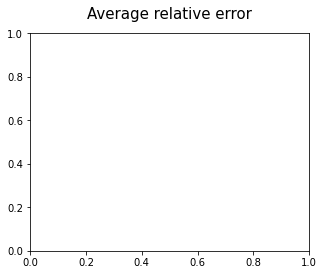

In [10]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)

plt.figure(1,figsize=(17,4))
ax=plt.subplot(1,3,1)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(errors[0].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(errors[1].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(errors[2].reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

8


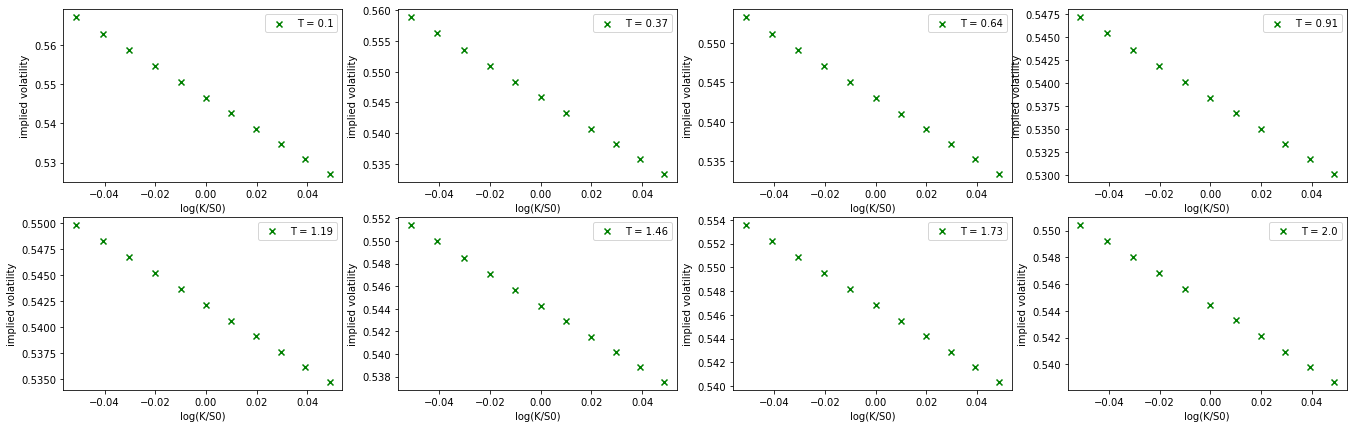

In [11]:
# call_prices
axisX = []
axisY = []
strikes_dim=len(strikes)
maturities_dim=len(maturities)

for i in range(maturities_dim):
    x = []
    y = []
    for j in range(strikes_dim):
        try:
            y.append(impliedVol(S0, strikes[j], maturities[i], call_prices[i*strikes_dim + j]))
            x.append(np.log(strikes[j]/S0))
        except:
            pass
    axisX.append(x)
    axisY.append(y)
    
print(len(axisX)) 
f = plt.figure(1, figsize=(23, 7))
for i in range(len(maturities)):
    plt.subplot(2, 4, i+1)
    plt.scatter(axisX[i], axisY[i], c='g', marker='x', label="T = %s"%maturities[i])
    plt.xlabel("log(K/S0)")
    plt.ylabel("implied volatility")
    plt.legend(loc=1)
plt.show();

In [ ]:
# time = np.arange(N)
# f = plt.figure(figsize=(16,4))
# ax1 = plt.subplot(121)
# ax1.plot(time, S, label = "qrHeston")
# ax1.grid()
# ax1.set_xlabel("time")
# ax1.set_ylabel("Prices")
# ax1.legend(loc=1)

# ax2 = plt.subplot(122)
# ax2.plot(time, iv, label = "qrHeston")
# ax2.grid()
# ax2.set_xlabel("time")
# ax2.set_ylabel("implied volatility")
# ax2.legend(loc=1)
# plt.show()


In [1]:
import multiprocessing

multiprocessing.cpu_count()

4

In [ ]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)

x = np.log(strikes/S0)
f = plt.figure(1, figsize=(23, 7))
for i in range(len(maturities)):
    plt.subplot(2, 4, i+1)
    y = ivs_[7][i*strikes_dim: (i+1)*strikes_dim]
    plt.scatter(x, y, c='g', marker='x', label="T = %s"%maturities[i])
    plt.xlabel("log(K/S0)")
    plt.ylabel("implied volatility")
    plt.legend(loc=1)
plt.show();